### Brain MRI segmentation with Unet 

The data were taken from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

#### Import the libraries

In [8]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Import the data 

In [11]:
DataPath = "lgg-mri-segmentation/kaggle_3m/"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))
            
            
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [12]:
imagePath_df.head()

,directory,images,masks
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif
2,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif
3,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif
4,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_14.tif,TCGA_CS_4941_19960909_14_mask.tif


In [13]:
imagePath_df.shape

(3929, 3)

In [ ]:
# Check the size of the image





In [14]:
# Check the size of the image 

def print_imShape():
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    print(image.shape, mask.shape)
    
    
for i in range(5):
    print_imShape()    
    

(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


### Visualize the data 

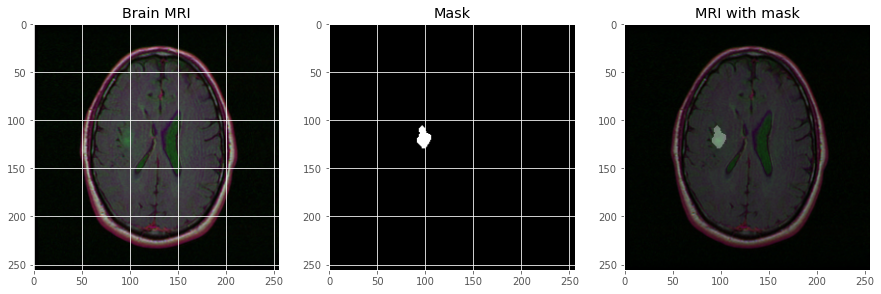

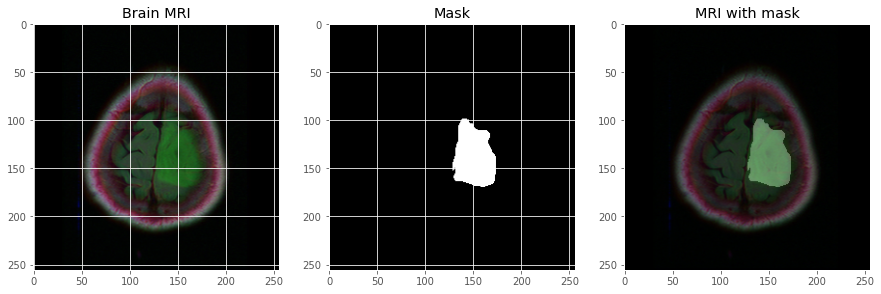

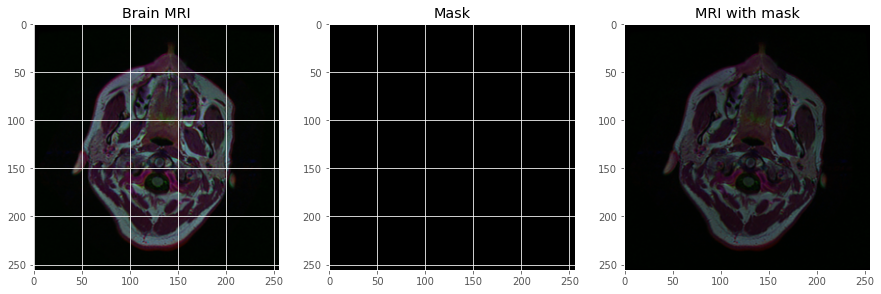

In [23]:
def plot_images():
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[15,15])
    
    axs[0].imshow(image)
    axs[0].set_title('MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()
    
    
for i in range(3):
    plot_images()

In [24]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 

In [27]:
# Finaldataframe with image and mask directories 
imagePath_df.head(2)


,directory,images,masks,image-path,mask-path
0,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_10.tif,TCGA_CS_4941_19960909_10_mask.tif,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...
1,TCGA_CS_4941_19960909,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...


### Data Generator 

##### Train Data 

In [28]:
train , test = train_test_split(imagePath_df, test_size=0.25)


EPOCHS = 35
BATCH_SIZE = 32
ImgHieght = 256
ImgWidth = 256
Channels = 3


# Data Augmentation 

data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')




# image and mask generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale') 


Found 2946 validated image filenames.
Found 2946 validated image filenames.


###### Test Data 

In [29]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')  

Found 983 validated image filenames.
Found 983 validated image filenames.


In [31]:
# Create a  function for generating the images and masks 
def data_gen(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [32]:
train_gen = data_gen(timage_generator, tmask_generator)
valid_gen = data_gen(vimage_generator, vmask_generator)


##### Create Unet 

In [37]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [38]:

def unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    
    # Encoding 
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Decoding 
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [39]:
# Compile the model

input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model = unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [41]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

### Train the model 

In [42]:
# Callbacks 

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [43]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [44]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/35
92/92 [==============================] - 83s 760ms/step - loss: 0.2305 - accuracy: 0.9683 - val_loss: 0.1956 - val_accuracy: 0.9905

Epoch 00001: val_loss improved from inf to 0.19563, saving model to model-brain-mri.h5
Epoch 2/35
92/92 [==============================] - 62s 677ms/step - loss: 0.0903 - accuracy: 0.9915 - val_loss: 0.0839 - val_accuracy: 0.9908

Epoch 00002: val_loss improved from 0.19563 to 0.08389, saving model to model-brain-mri.h5
Epoch 3/35
92/92 [==============================] - 71s 775ms/step - loss: 0.0591 - accuracy: 0.9919 - val_loss: 0.0511 - val_accuracy: 0.9918

Epoch 00003: val_loss improved from 0.08389 to 0.05108, saving model to model-brain-mri.h5
Epoch 4/35
92/92 [==============================] - 68s 741ms/step - loss: 0.0645 - accuracy: 0.9885 - val_loss: 0.0551 - val_accuracy: 0.9907

Epoch 00004: val_loss did not improve from 0.05108
Epoch 5/35
92/92 [==============================] - 59s 644ms/step - loss: 0.0382 - accuracy: 0.9920 - v

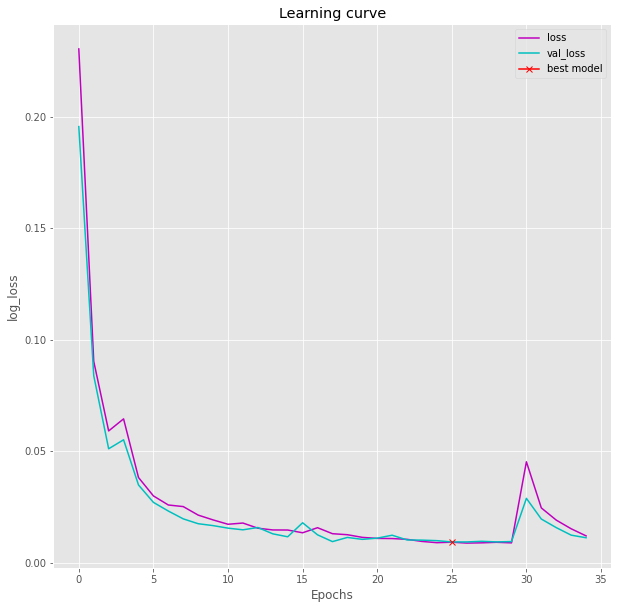

In [47]:
plt.figure(figsize=(10, 10))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color="m")
plt.plot(results.history["val_loss"], label="val_loss", color="c")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

#### Predictions 

In [48]:
# load the best model
model.load_weights('model-brain-mri.h5')

In [49]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

30/30 [==============================] - 2s 56ms/step - loss: 0.0095 - accuracy: 0.9967


#### Plot the predictions 

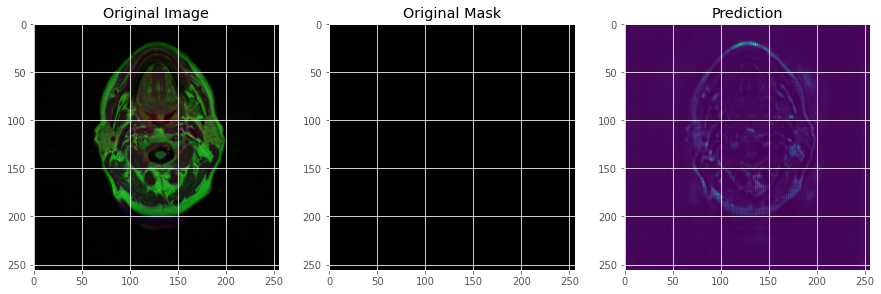

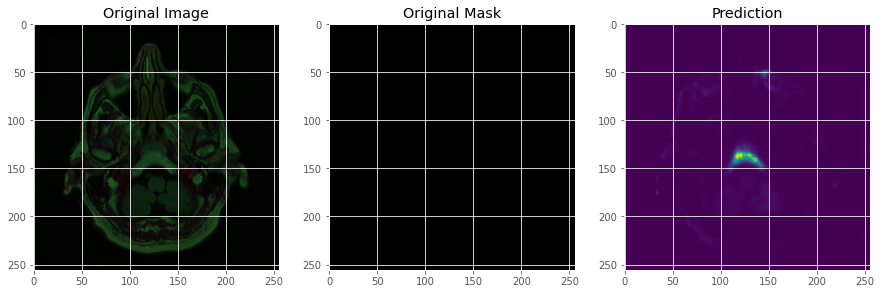

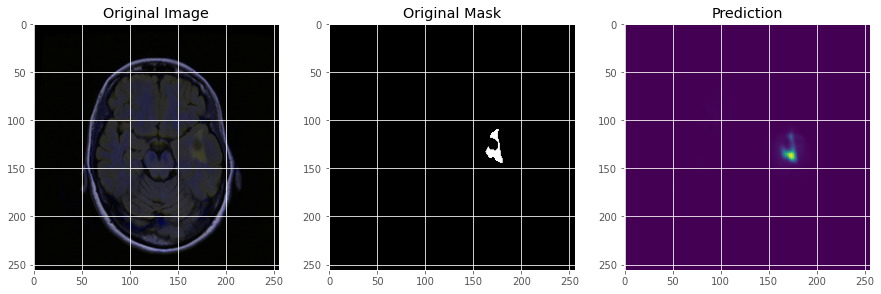

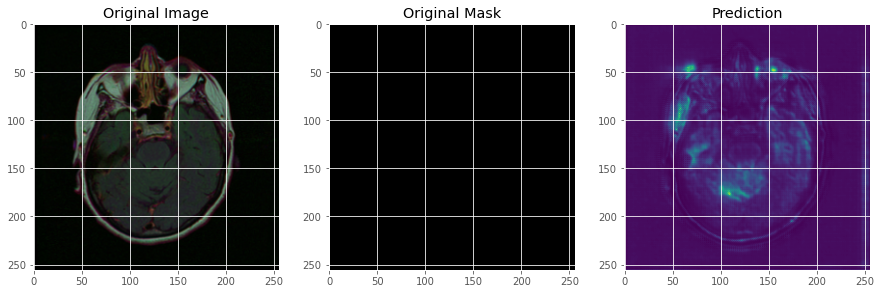

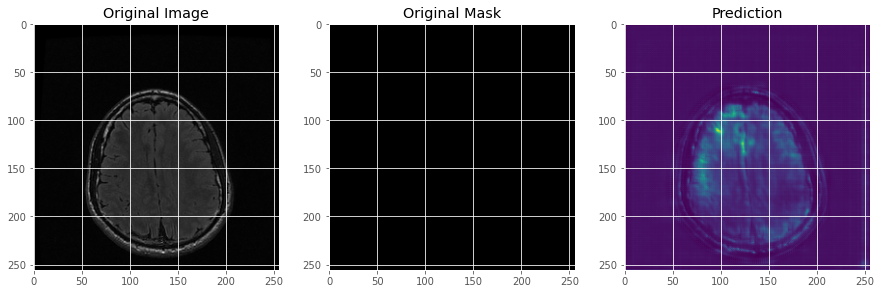

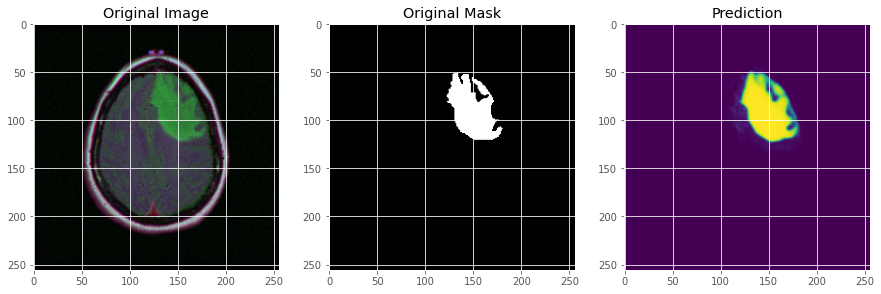

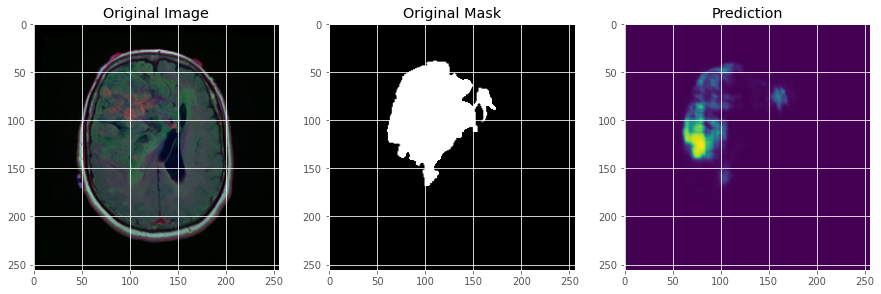

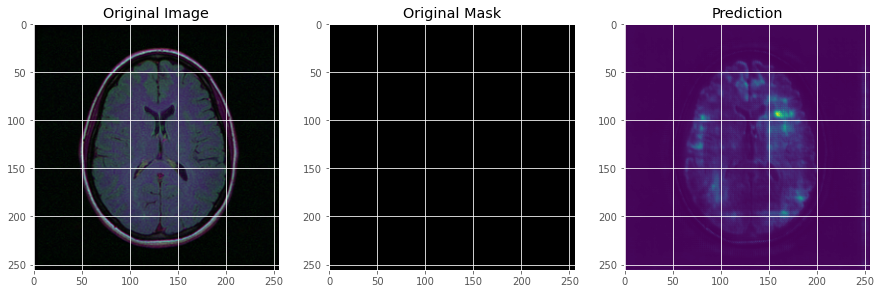

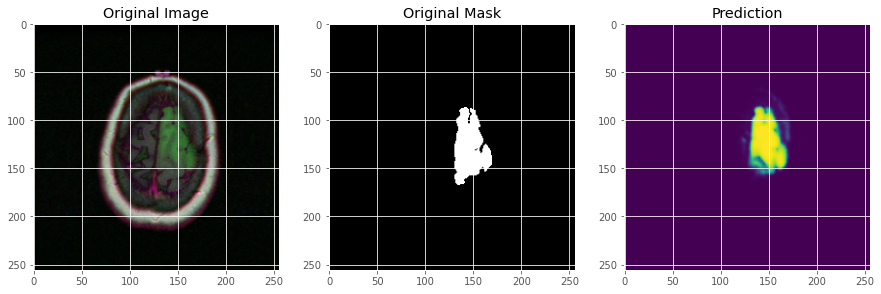

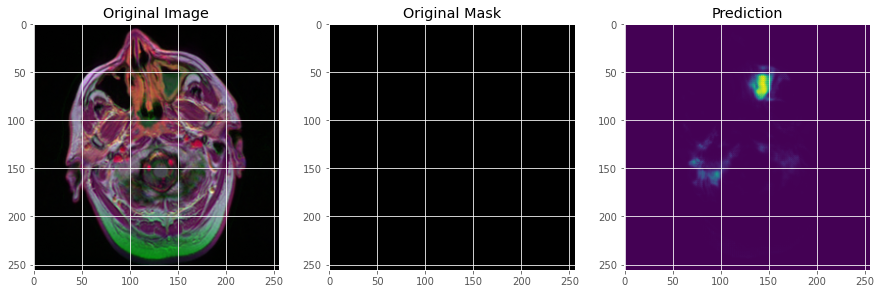

In [52]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')